# 2. Telcom Churn Prediction

Here’s a dataset of telecom customers, which you can also find on Kaggle. There is data available on 5,986 customers.

Which customers are likely to churn? What are the attributes that make you think so?

**This is a supervised learning classification problem**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

In [2]:
import warnings
# Suppress FutureWarning for the entire script
warnings.filterwarnings("ignore", category=FutureWarning)

- Load dataset
- Analyse which columns to drop (data leakage)
- Analyse and clean missing data (imputing)
- Analyse and clean balancing (SMOTE, SMOTENC)
- Onehot encode data
- Split data
- Scale data
- Analysis

Data leakage and connections:
- Exclude "customerID" and "churn" for segmentation
- MultipleLines=yes implies PhoneService=yes
- PhoneService=No implies MulitpleLines=No
- OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies = No if InternetService=No

-> "PhoneService" can be dropped (information is contained in "MultipleLines")<br>
-> "CustomerID" can be dropped<br>
-> "Unnamed 0" must be dropped (what is it anyway?)<br>
-> "Churn" must be dropped for segmentation and training<br>
-> Suggest to leave "InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies" as is (?)<br>

Imbalance:
- Churn: 4399
- No churn: 1587

Duplicates: 
- No duplicates

Missing Values:
- No missing values

Unique categorical values:
- Maximum is 4


### Read in the dataset

In [3]:
# hard coded
df = pd.read_csv("telecom_users.csv")
df

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.3,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


In [5]:
# Convert "TotalCharges" to float64
# Convert to float, setting non-convertible values to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [6]:
# Drop rows where any column contains NaN values
df = df.dropna()
# Check for NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5976 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5976 non-null   int64  
 1   customerID        5976 non-null   object 
 2   gender            5976 non-null   object 
 3   SeniorCitizen     5976 non-null   int64  
 4   Partner           5976 non-null   object 
 5   Dependents        5976 non-null   object 
 6   tenure            5976 non-null   int64  
 7   PhoneService      5976 non-null   object 
 8   MultipleLines     5976 non-null   object 
 9   InternetService   5976 non-null   object 
 10  OnlineSecurity    5976 non-null   object 
 11  OnlineBackup      5976 non-null   object 
 12  DeviceProtection  5976 non-null   object 
 13  TechSupport       5976 non-null   object 
 14  StreamingTV       5976 non-null   object 
 15  StreamingMovies   5976 non-null   object 
 16  Contract          5976 non-null   object 
 17  

In [7]:
# Check for balancing
df.Churn.value_counts()

Churn
No     4389
Yes    1587
Name: count, dtype: int64

In [8]:
# Check for duplicates
duplicate_rows = df[df.duplicated()]
duplicate_rows

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [9]:
column_list = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]
# Loop through all columns and get value counts
for column in column_list:
    value_counts = df[column].unique()
    print(value_counts)
    print()

['Male' 'Female']

[0 1]

['Yes' 'No']

['Yes' 'No']

['Yes' 'No']

['Yes' 'No' 'No phone service']

['No' 'Fiber optic' 'DSL']

['No internet service' 'No' 'Yes']

['No internet service' 'Yes' 'No']

['No internet service' 'Yes' 'No']

['No internet service' 'No' 'Yes']

['No internet service' 'Yes' 'No']

['No internet service' 'No' 'Yes']

['Two year' 'Month-to-month' 'One year']

['No' 'Yes']

['Credit card (automatic)' 'Bank transfer (automatic)' 'Electronic check'
 'Mailed check']



## Distribution Analysis

In [10]:
df.columns

Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

In [11]:
numerical_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [
    "gender", "Partner", "Dependents", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]
target = ["Churn"]

In [12]:

all_features = categorical_features + numerical_features
len(all_features)

18

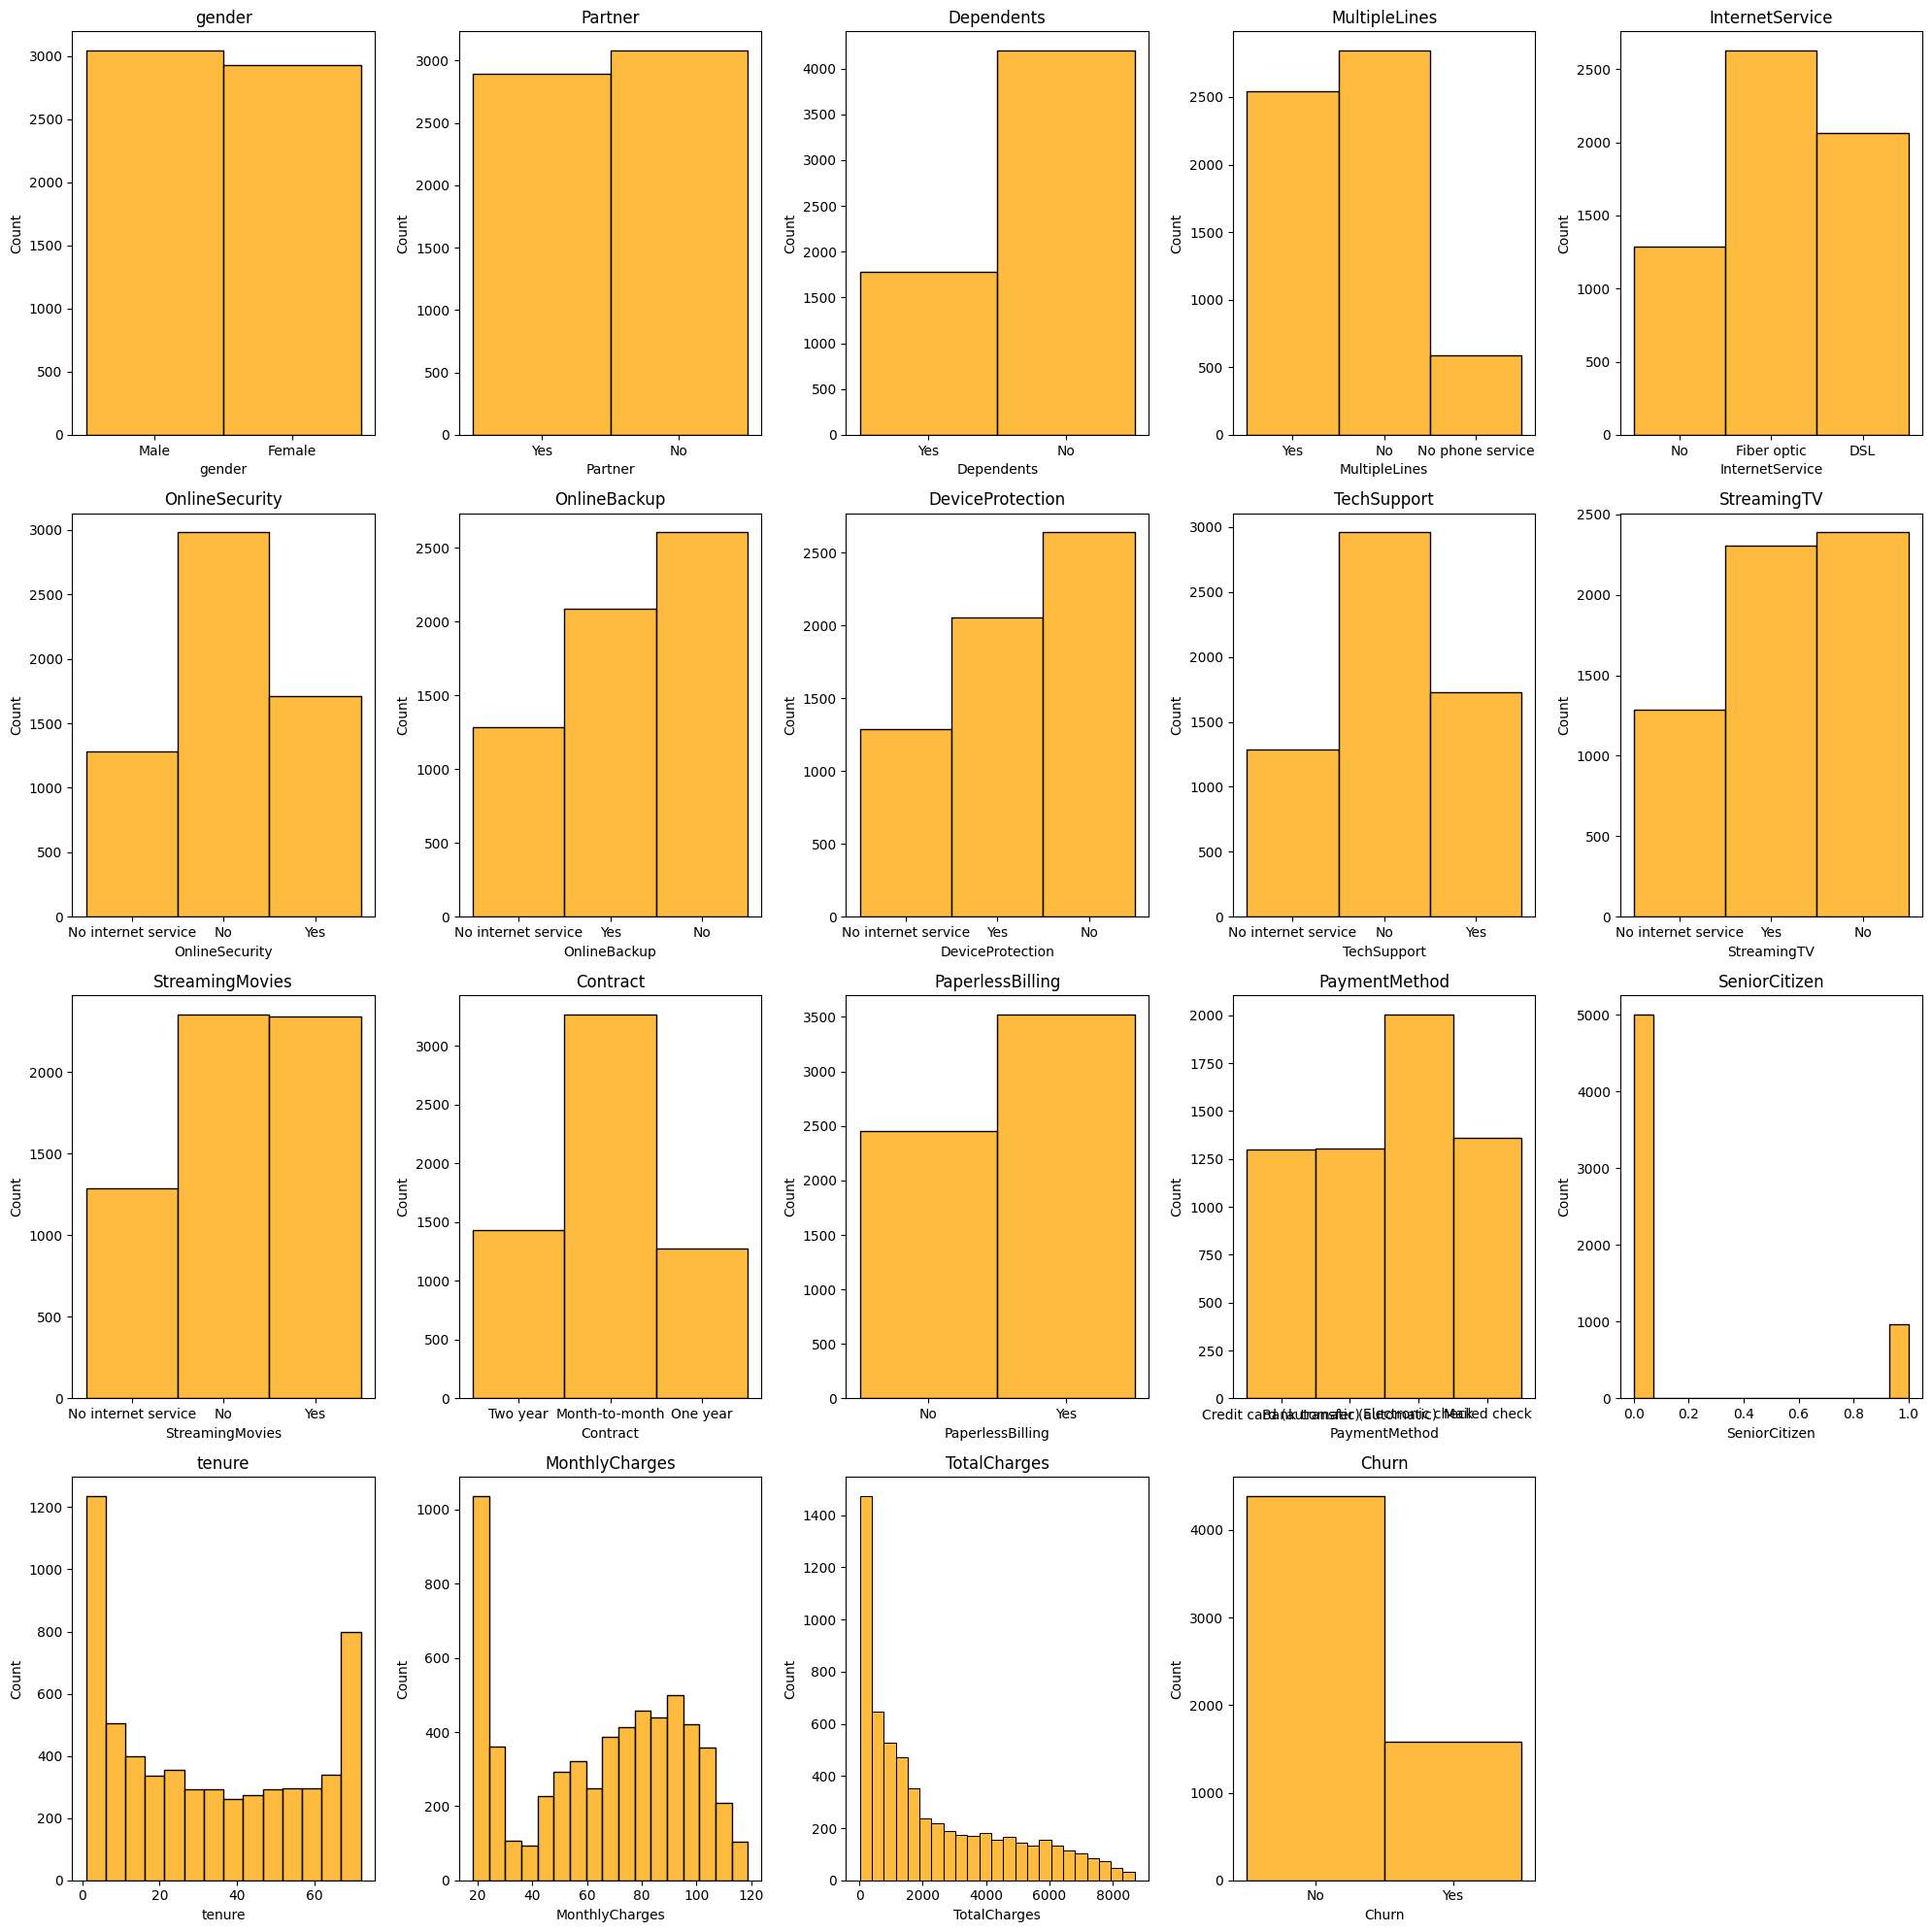

In [13]:
# Histograms: 34 columns, we do a 7 rows, 5 columns plot
to_plot = all_features + target
num_cols = len(to_plot)


# Create subplots:
fig, axes = plt.subplots(4, 5, figsize=(20, 20))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axes):
    if i < num_cols:
        feature = to_plot[i]
        # Plot data on each subplot
        sns.histplot(df[feature], ax=ax, color="orange")
        ax.set_title(f'{feature}')  # Set title for each subplot
        
            

# Remove the last subplot
fig.delaxes(axes[-1])

# Adjust layout and spacing
plt.tight_layout()
plt.show()

## Clustering

In [14]:
# Define the dataframe for clustering, i.e. df[all_features]
X = df[all_features]

### Clustering using K-means

In [15]:
cluster_errors = []
silhouette_s = []
clusters = 10


# Create the ColumnTransformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # One-hot encode only categorical columns
        ('num', StandardScaler(with_mean=False), numerical_features)  # Scale only numerical columns
    ])

# Try 2 to 20 clusters
for n_clusters in range(2, clusters):
    # Define the pipeline
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Apply the preprocessor defined above
        ('cluster', KMeans(n_clusters=n_clusters, random_state=42, verbose=0))  # KMeans clustering
    ])
    kmeans_pipeline.fit(X)

    # Within cluster error
    wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
    cluster_errors.append(wcsse)
    
    # Silouette score
    cluster_labels = kmeans_pipeline.fit_predict(X)
    #silhouette_s.append(silhouette_score(X, cluster_labels))



In [ ]:
# Elbow:
plt.plot(range(2, clusters), cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("SSE")
plt.show()

In [16]:
# To get the feature names for the entire pipeline output:
feature_names = kmeans_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names

array(['cat__gender_Female', 'cat__gender_Male', 'cat__Partner_No',
       'cat__Partner_Yes', 'cat__Dependents_No', 'cat__Dependents_Yes',
       'cat__MultipleLines_No', 'cat__MultipleLines_No phone service',
       'cat__MultipleLines_Yes', 'cat__InternetService_DSL',
       'cat__InternetService_Fiber optic', 'cat__InternetService_No',
       'cat__OnlineSecurity_No',
       'cat__OnlineSecurity_No internet service',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_No',
       'cat__OnlineBackup_No internet service', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_No',
       'cat__DeviceProtection_No internet service',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_No',
       'cat__TechSupport_No internet service', 'cat__TechSupport_Yes',
       'cat__StreamingTV_No', 'cat__StreamingTV_No internet service',
       'cat__StreamingTV_Yes', 'cat__StreamingMovies_No',
       'cat__StreamingMovies_No internet service',
       'cat__StreamingMovies_Yes', 'cat__Contrac

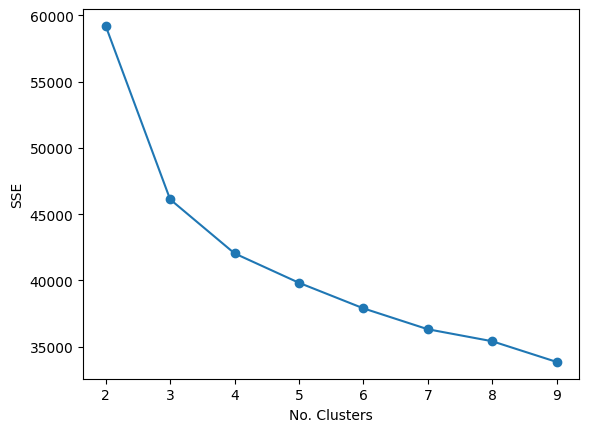

In [17]:
# Elbow:
plt.plot(range(2, clusters), cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("SSE")
plt.show()

In [18]:
df

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95.00,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.30,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


In [19]:
n_clusters=4

kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Apply the preprocessor defined above
        ('cluster', KMeans(n_clusters=n_clusters, random_state=42, verbose=0))  # KMeans clustering
    ])
kmeans_pipeline.fit(X)


wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
print('K = ', n_clusters, '\tWCSS Err. = ', wcsse)

# Predict the cluster labels for each data point
cluster_labels = kmeans_pipeline.predict(X)
df["cluster"] = cluster_labels

X

K =  4 	WCSS Err. =  42040.62334825813


/var/folders/ld/c81z579x7n940m4_d4tq448m0000gp/T/ipykernel_62301/699822547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,Male,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,72,24.10,1734.65
1,Female,No,No,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),0,44,88.15,3973.20
2,Female,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1,38,74.95,2869.85
3,Male,No,No,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0,4,55.90,238.50
4,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,0,2,53.45,119.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,Male,Yes,No,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0,1,95.00,95.00
5982,Female,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0,23,91.10,2198.30
5983,Male,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,0,12,21.15,306.05
5984,Male,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,12,99.45,1200.15


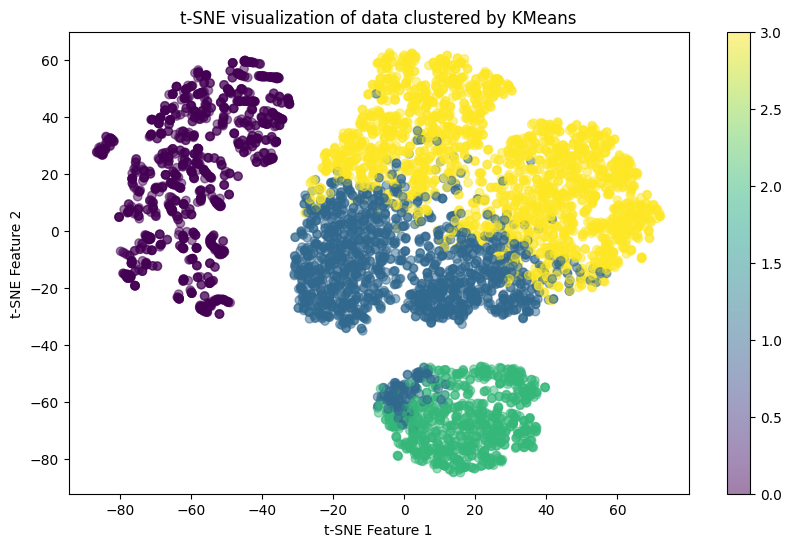

In [20]:
X_transformed = kmeans_pipeline.named_steps['preprocessor'].transform(X)

# Now apply t-SNE to the transformed data
tsne = TSNE(n_components=2, random_state=42)  # Using 2 components for a 2D visualization
X_tsne = tsne.fit_transform(X_transformed)

# You might want to visualize the t-SNE output
# Get the cluster labels from KMeans to color the t-SNE plot accordingly
cluster_labels = kmeans_pipeline.named_steps['cluster'].labels_

# Plotting the results of t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of data clustered by KMeans')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

### Compare with feature values

In [21]:
X_ = pd.DataFrame(X_transformed)
X_

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,2.938919,0.800530,0.762840
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.796006,2.928080,1.747278
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.716459,1.551096,2.489615,1.262062
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.163273,1.856831,0.104884
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.081637,1.775449,0.052552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.040818,3.155616,0.041778
5972,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.938821,3.026070,0.966737
5973,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.489820,0.702540,0.134590
5974,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.716459,0.489820,3.303432,0.527785


#### Compare with Churn column

In [22]:
df["churn_01"] = df.Churn.apply(lambda x: 1 if x=="Yes" else 0)

/var/folders/ld/c81z579x7n940m4_d4tq448m0000gp/T/ipykernel_62301/1008907251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["churn_01"] = df.Churn.apply(lambda x: 1 if x=="Yes" else 0)


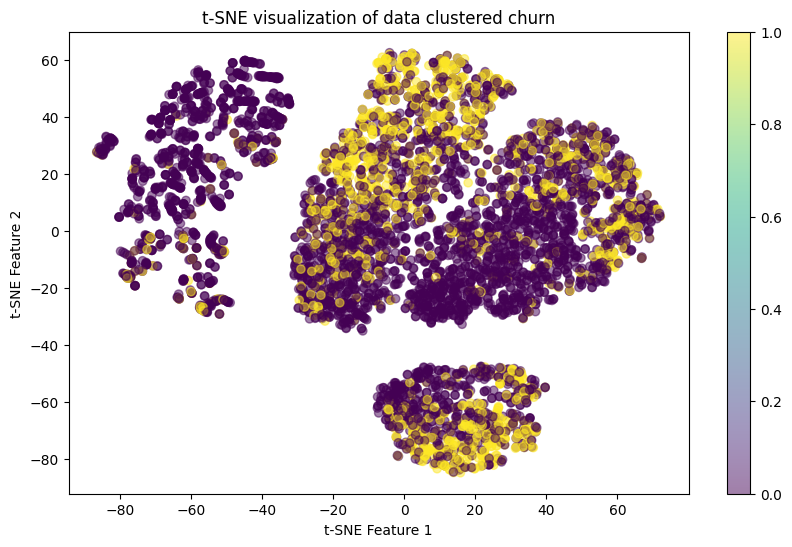

In [23]:
# Plotting the results of t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["churn_01"], cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of data clustered churn')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

#### Compare with "Internet Service"

In [24]:
def internet(service):
    if service == "No":
        return 2
    elif service == "DSL":
        return 1
    else:
        return 0
        
df["internet"] = df.InternetService.apply(lambda x: internet(x))

/var/folders/ld/c81z579x7n940m4_d4tq448m0000gp/T/ipykernel_62301/2697105558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["internet"] = df.InternetService.apply(lambda x: internet(x))


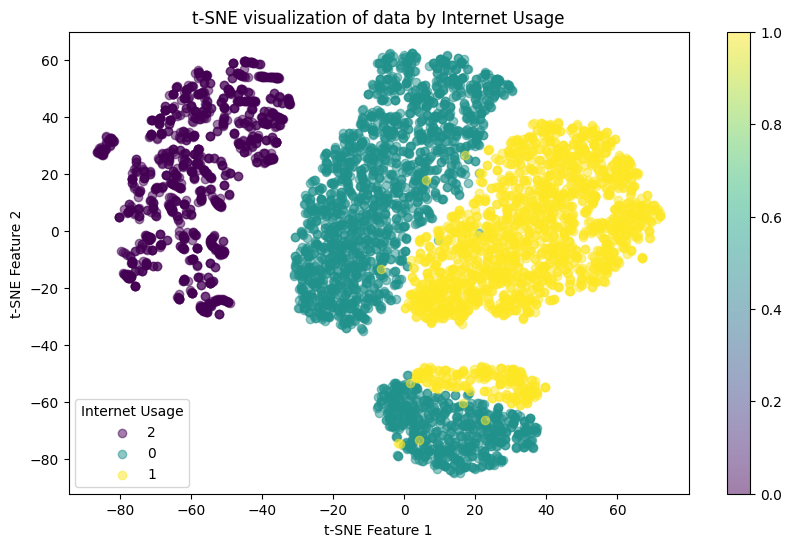

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

In [25]:
# Assuming 'X_tsne' is the result from t-SNE and 'df["internet"]' contains categorical data
unique_categories = df["internet"].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_categories)))  # Generate colors from the viridis colormap

plt.figure(figsize=(10, 6))

# Plot each category with a separate label and color
for category, color in zip(unique_categories, colors):
    # Select indices for data points in this category
    indices = df["internet"] == category
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=[color], label=str(category), alpha=0.5)

plt.colorbar()  # Optional: Shows color scale, might not be needed with legend
plt.title('t-SNE visualization of data by Internet Usage')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Internet Usage')  # Add legend with title
plt.show()
colors

### Compare with "Contract"

/var/folders/ld/c81z579x7n940m4_d4tq448m0000gp/T/ipykernel_62301/691589339.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["contract"] = df.Contract.apply(contract)


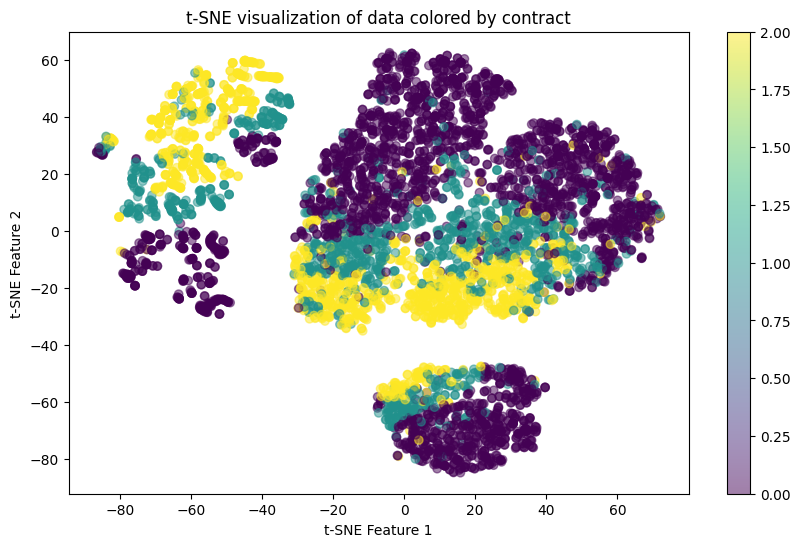

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster,churn_01,internet,contract
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,Two year,No,Credit card (automatic),24.10,1734.65,No,0,0,2,2
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No,1,0,0,0
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes,2,1,0,0
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,Month-to-month,Yes,Electronic check,55.90,238.50,No,3,0,1,0
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Month-to-month,No,Electronic check,53.45,119.50,No,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,...,Month-to-month,Yes,Electronic check,95.00,95.00,Yes,3,1,0,0
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,...,Two year,Yes,Credit card (automatic),91.10,2198.30,No,1,0,1,2
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,...,Month-to-month,Yes,Electronic check,21.15,306.05,No,0,0,2,0
5984,5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,...,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes,2,1,0,0


In [26]:
#'Two year' 'Month-to-month' 'One year'

def contract(service):
    if str(service) == "Month-to-month":
        return 0
    elif str(service) == "One year":
        return 1
    else:
        return 2

df["contract"] = df.Contract.apply(contract)

# Plotting the results of t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["contract"], cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of data colored by contract')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()
df

### Evaluate Models using Pycaret

In [27]:
# check installed version
import pycaret
pycaret.__version__

'3.3.2'

In [28]:
# Drop the not needed rows
df = df.drop(columns={"Unnamed: 0", "customerID", "PhoneService", "cluster", "churn_01", "internet", "contract"})
df

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,1,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,0,No,No,2,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,Male,0,Yes,No,1,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95.00,Yes
5982,Female,0,Yes,Yes,23,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.30,No
5983,Male,0,Yes,Yes,12,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,Male,1,No,No,12,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


In [29]:
# Setup pycaret logging
%env MLFLOW_TRACKING_URI=https://b22a-34-23-135-153.ngrok-free.app/


env: MLFLOW_TRACKING_URI=https://b22a-34-23-135-153.ngrok-free.app/


In [30]:
# loading data
data = df
data

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,1,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,0,No,No,2,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,Male,0,Yes,No,1,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95.00,Yes
5982,Female,0,Yes,Yes,23,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.30,No
5983,Male,0,Yes,Yes,12,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,Male,1,No,No,12,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


In [31]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data, target = "Churn", session_id = 123, log_experiment = False, experiment_name = "laurent_02")

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5976, 19)"
5,Transformed data shape,"(5976, 40)"
6,Transformed train set shape,"(4183, 40)"
7,Transformed test set shape,"(1793, 40)"
8,Numeric features,4
9,Categorical features,14


In [32]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [33]:
# check the type of exp
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [34]:
# init setup on exp
exp.setup(data, target = "Churn", session_id = 123)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5976, 19)"
5,Transformed data shape,"(5976, 40)"
6,Transformed train set shape,"(4183, 40)"
7,Transformed test set shape,"(1793, 40)"
8,Numeric features,4
9,Categorical features,14


In [35]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7980,0.8402,0.7980,0.7880,0.7893,0.4432,0.4498,0.0680
lr,Logistic Regression,0.7968,0.8362,0.7968,0.7876,0.7892,0.4446,0.4501,0.2460
ridge,Ridge Classifier,0.7961,0.8297,0.7961,0.7858,0.7862,0.4335,0.4421,0.0150
ada,Ada Boost Classifier,0.7956,0.8358,0.7956,0.7851,0.7870,0.4372,0.4431,0.0320
lightgbm,Light Gradient Boosting Machine,0.7937,0.8261,0.7937,0.7850,0.7871,0.4407,0.4447,0.5850
lda,Linear Discriminant Analysis,0.7906,0.8295,0.7906,0.7827,0.7849,0.4366,0.4398,0.0150
rf,Random Forest Classifier,0.7827,0.8167,0.7827,0.7694,0.7716,0.3939,0.4013,0.0540
et,Extra Trees Classifier,0.7645,0.7872,0.7645,0.7519,0.7553,0.3546,0.3593,0.0540
knn,K Neighbors Classifier,0.7602,0.7303,0.7602,0.7452,0.7485,0.3333,0.3399,0.1040
svm,SVM - Linear Kernel,0.7569,0.7211,0.7569,0.7611,0.7380,0.3262,0.3546,0.0190


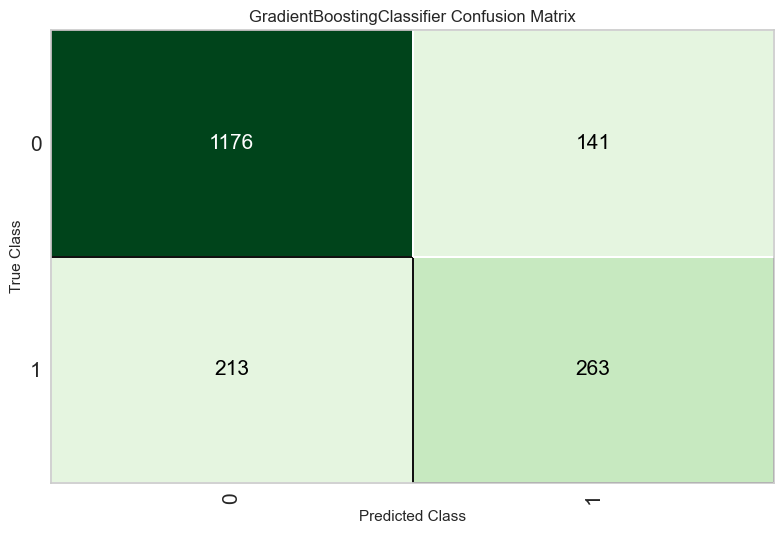

In [36]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

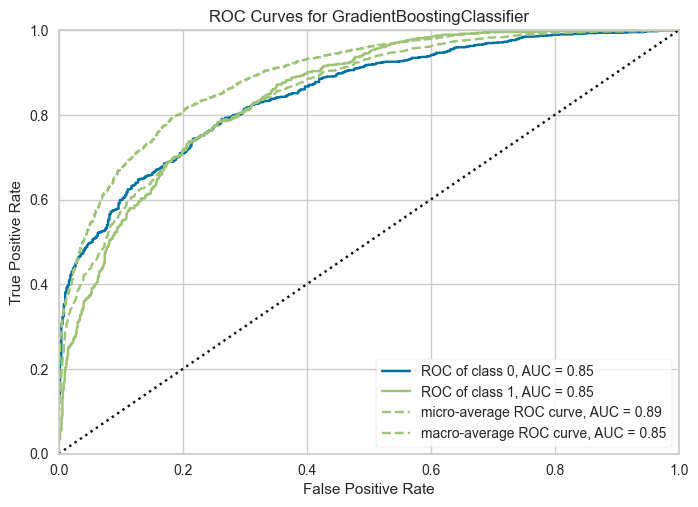

In [37]:
# plot AUC
plot_model(best, plot = 'auc')

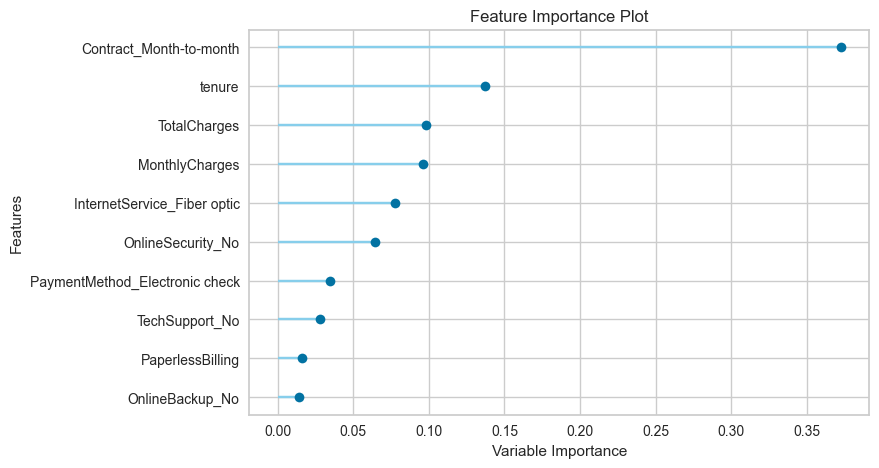

In [38]:
# plot feature importance
plot_model(best, plot = 'feature')

In [39]:
# Create a Gradient Boosting Classifier model
gb_model = create_model('gbc')

# Tune the model
tuned_gb_model = tune_model(gb_model)

# Evaluate the tuned model
evaluate_model(tuned_gb_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7876,0.8335,0.7876,0.7744,0.7764,0.4049,0.4127
1,0.7613,0.8079,0.7613,0.7513,0.7551,0.3576,0.3595
2,0.8019,0.8446,0.8019,0.7906,0.7908,0.4455,0.4554
3,0.8038,0.8222,0.8038,0.7944,0.7964,0.4631,0.4680
4,0.8230,0.8653,0.8230,0.8150,0.8156,0.5125,0.5190
5,0.8134,0.8380,0.8134,0.8035,0.8014,0.4698,0.4828
6,0.7871,0.8519,0.7871,0.7782,0.7811,0.4261,0.4287
7,0.7823,0.8292,0.7823,0.7722,0.7754,0.4096,0.4128
8,0.8038,0.8463,0.8038,0.7923,0.7912,0.4426,0.4549


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7852,0.8378,0.7852,0.7723,0.7550,0.3332,0.3720
1,0.7757,0.8193,0.7757,0.7574,0.7566,0.3447,0.3605
2,0.7947,0.8505,0.7947,0.7851,0.7691,0.3771,0.4126
3,0.7823,0.8162,0.7823,0.7656,0.7595,0.3503,0.3740
4,0.8110,0.8711,0.8110,0.8087,0.7864,0.4205,0.4629
5,0.7990,0.8291,0.7990,0.7889,0.7762,0.3942,0.4253
6,0.7919,0.8407,0.7919,0.7777,0.7737,0.3911,0.4101
7,0.7775,0.8270,0.7775,0.7595,0.7515,0.3270,0.3541
8,0.7823,0.8530,0.7823,0.7687,0.7509,0.3231,0.3626


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [40]:
# Save the tuned model
save_model(tuned_gb_model, 'saved_gb_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SeniorCitizen', 'tenure',
                                              'MonthlyCharges', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                                             max

### Use the model for real data

In [41]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,1,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,0,No,No,2,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,Male,0,Yes,No,1,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95.00,Yes
5982,Female,0,Yes,Yes,23,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.30,No
5983,Male,0,Yes,Yes,12,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,Male,1,No,No,12,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


In [42]:

# Create a contingency table
contingency_table = pd.crosstab(df['Contract'], df['Churn'])

# Plotly stacked bar plot
fig = go.Figure()

for churn_status in contingency_table.columns:
    fig.add_trace(go.Bar(
        x=contingency_table.index,
        y=contingency_table[churn_status],
        name=churn_status
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Contract',
    yaxis_title='Count',
    title='Churn by Contract Type'
)

# Show the plot
fig.show()

**Customers with short term contracts are more likely to churn**

In [43]:


# Create a contingency table
contingency_table = pd.crosstab(df['InternetService'], df['Churn'])

# Plotly stacked bar plot
fig = go.Figure()

for churn_status in contingency_table.columns:
    fig.add_trace(go.Bar(
        x=contingency_table.index,
        y=contingency_table[churn_status],
        name=churn_status
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Internet Service',
    yaxis_title='Count',
    title='Churn by Internet Service'
)

# Show the plot
fig.show()


In [44]:


# Create a contingency table
contingency_table = pd.crosstab(df['tenure'], df['Churn'])

# Plotly stacked bar plot
fig = go.Figure()

for churn_status in contingency_table.columns:
    fig.add_trace(go.Bar(
        x=contingency_table.index,
        y=contingency_table[churn_status],
        name=churn_status
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Tenure (months)',
    yaxis_title='Count',
    title='Churn by tenure'
)

# Show the plot
fig.show()


**Customers with longer tenure (more than 24 month) hardly ever churn**

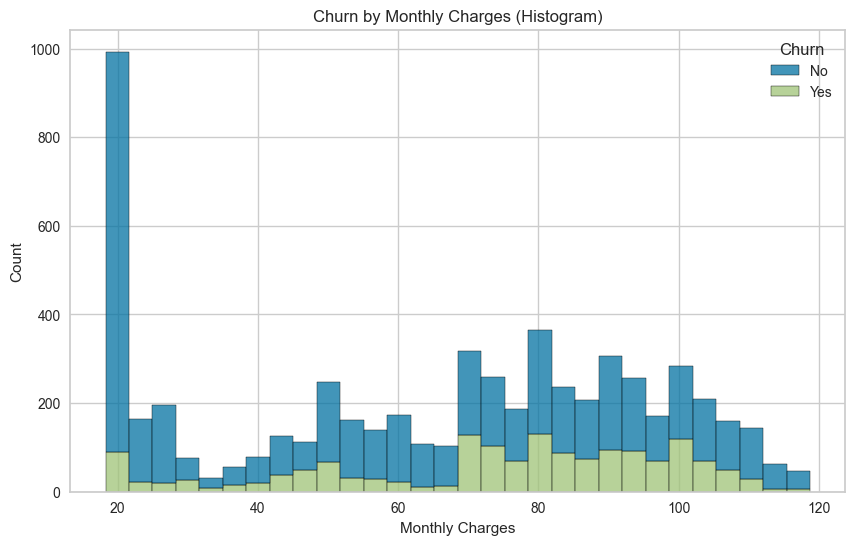

In [45]:
# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', bins=30)
plt.title('Churn by Monthly Charges (Histogram)')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.show()

**Customers with short term contracts are more likely to churn**

**Customers with high monthly charges are more likely to churn**

**Customers with longer tenure (more than 24 month) hardly ever churn**

### **Conclusion**: 
**Make attractive offers or promotions for longer term contracts and from time to time pamper those with high monthly charges with some benefits.**